In [ ]:
import sys
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft
from matplotlib.animation import FuncAnimation

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
h5_files = glob.glob(os.path.join("..\\output", "*.h5"))

eta_hat, phi_hat, Hs, Tp, modes, time, length, x = None, None, None, None, None, None, None, None

with h5py.File("Z:\\files\\simulation.h5", "r") as data:
    eta_hat = data["eta_hat"][:]
    phi_hat = data["phi_hat"][:]
    Hs = data["Hs"][:]
    Tp = data["Tp"][:]
    time = data["time"][:]

    modes = data.attrs["modes"]
    length = data.attrs["length"]
    Ta = data.attrs["Ta"]
    x = np.linspace(0, length, 2*modes)

index = np.argmin(np.abs(time - 2*Ta))

eta_hat = eta_hat[:, index:, :]
phi_hat = phi_hat[:, index:, :]
time = time[index:] - time[index]

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from numpy.fft import irfft, rfft

inputs = keras.Input(shape=(1026,))
x_ = layers.Dense(512, activation='relu')(inputs)
x_ = layers.Dense(512, activation='relu')(x_)
outputs = layers.Dense(1026)(x_)

# inputs = keras.Input(shape=(1026, 1))  # Add channel dimension for CNN
# x_ = layers.Conv1D(32, kernel_size=5, padding='same', activation='relu')(inputs)
# x_ = layers.Conv1D(32, kernel_size=5, padding='same', activation='relu')(x_)
# x_ = layers.Conv1D(32, kernel_size=5, padding='same', activation='relu')(x_)
# x_ = layers.Conv1D(1, kernel_size=5, padding='same')(x_)  # Output one channel
# outputs = layers.Flatten()(x_)  # Flatten to (1026,) output

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

# model.summary()
prediction_time = 60
train_percentage = 0.9
batch_size = 32

# X = eta_hat[0, :-prediction_time, :]
# y = eta_hat[0, prediction_time:, :]
# X = irfft(X)
# y = irfft(y)

X = eta_hat[0, :-prediction_time, :]
y = eta_hat[0, prediction_time:, :]
X = np.concatenate((np.real(X), np.imag(X)), axis=1)
y = np.concatenate((np.real(y), np.imag(y)), axis=1)


X_train = X[:int(X.shape[0]*train_percentage), :]
X_test = X[int(X.shape[0]*train_percentage):, :]
y_train = y[:int(y.shape[0]*train_percentage), :]
y_test = y[int(y.shape[0]*train_percentage):, :]

std = np.std(X)
X_train = X_train / std
y_train = y_train / std

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    batch_size=batch_size,
    epochs=1000,
    callbacks=[early_stopping],
    shuffle=True
)

Epoch 1/1000
45/45 [==============================] - 14s 43ms/step - loss: 0.9439 - mae: 0.4036 - val_loss: 0.8008 - val_mae: 0.4476
Epoch 2/1000
45/45 [==============================] - 1s 25ms/step - loss: 0.4935 - mae: 0.3934 - val_loss: 0.4906 - val_mae: 0.4130
Epoch 3/1000
45/45 [==============================] - 1s 20ms/step - loss: 0.2800 - mae: 0.3191 - val_loss: 0.3775 - val_mae: 0.3810
Epoch 4/1000
45/45 [==============================] - 1s 22ms/step - loss: 0.1937 - mae: 0.2734 - val_loss: 0.3060 - val_mae: 0.3491
Epoch 5/1000
45/45 [==============================] - 1s 22ms/step - loss: 0.1411 - mae: 0.2371 - val_loss: 0.2584 - val_mae: 0.3296
Epoch 6/1000
45/45 [==============================] - 1s 30ms/step - loss: 0.1086 - mae: 0.2100 - val_loss: 0.2340 - val_mae: 0.3137
Epoch 7/1000
45/45 [==============================] - 2s 37ms/step - loss: 0.0873 - mae: 0.1917 - val_loss: 0.2124 - val_mae: 0.2979
Epoch 8/1000
45/45 [==============================] - 2s 51ms/step -

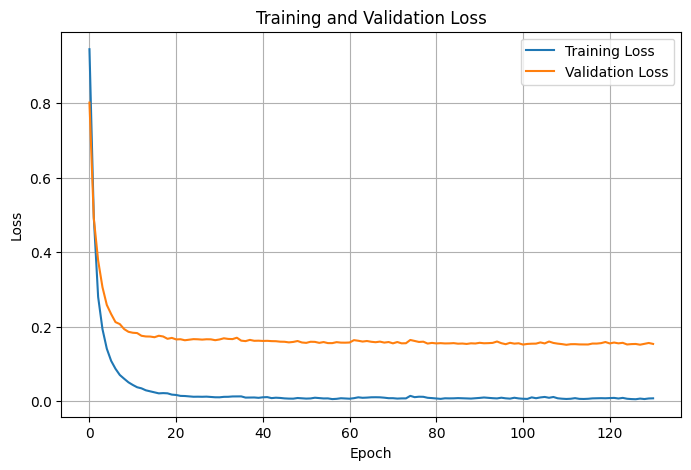

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()

6/6 [==============================] - 0s 19ms/step
Hs: 2.320m, MAE/Hs: 103.487%


ValueError: x and y must have same first dimension, but have shapes (1024,) and (1026,)

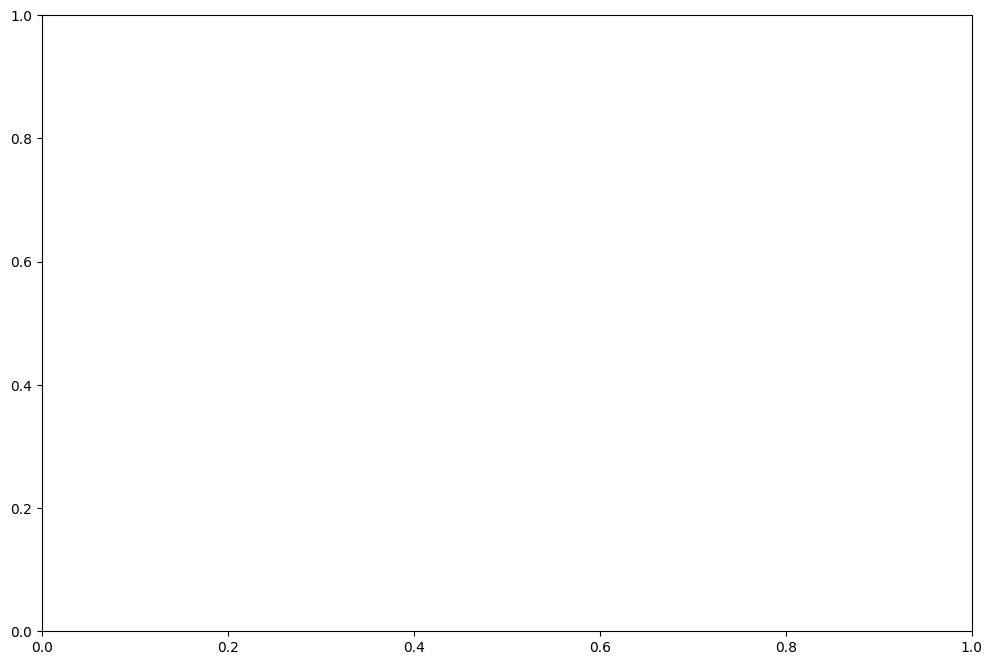

In [6]:
index = 0
y_pred = model.predict(X_test / std) * std
error = np.mean(np.mean(np.abs(y_pred - y_test), axis=-1))/Hs[0]*100
print(f"Hs: {Hs[0]:.3f}m, MAE/Hs: {error:.3f}%")
plt.figure(figsize=(12, 8))
plt.plot(x, y_pred[index], "r--", label="Prediction")
plt.plot(x, y_test[index], "k-", label="Ground Truth")
plt.xlim(x[0], x[-1])
plt.legend()
plt.grid()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Hs: 2.320m, MAE/Hs: 7.487%


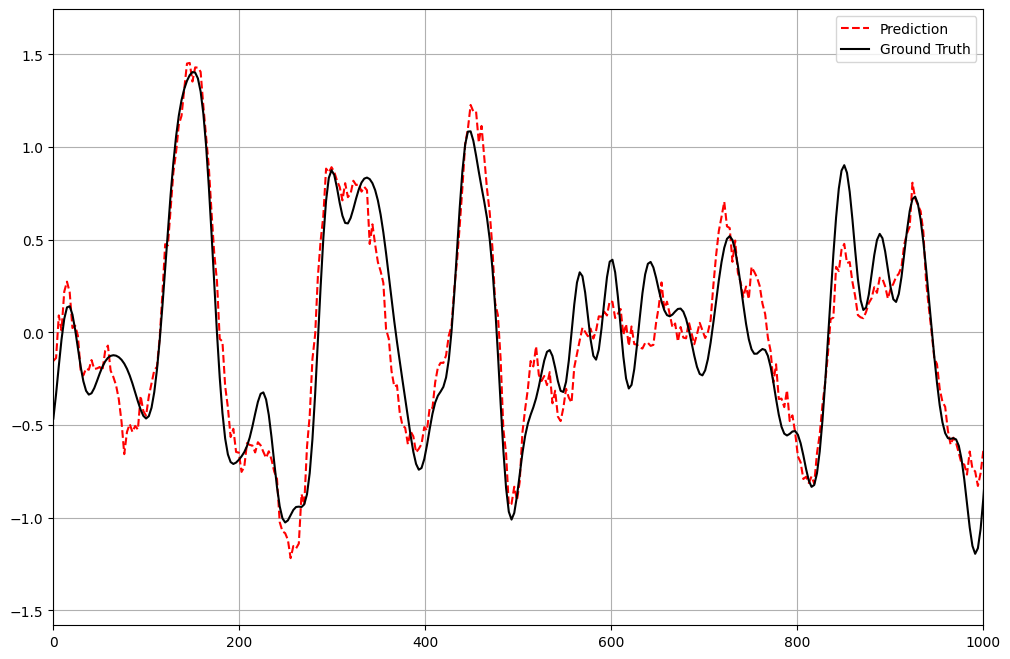

In [99]:
from numpy.fft import irfft

y_pred = model.predict(X_test / std) * std

index = 0
y_pred_real = irfft(y_pred[:, :513] + 1.j * y_pred[:, 513:])
y_test_real = irfft(y_test[:, :513] + 1.j * y_test[:, 513:])
error = np.mean(np.mean(np.abs(y_pred_real - y_test_real), axis=1))/Hs[0]*100
print(f"Hs: {Hs[0]:.3f}m, MAE/Hs: {error:.3f}%")
plt.figure(figsize=(12, 8))
plt.plot(x, y_pred_real[0], "r--", label="Prediction")
plt.plot(x, y_test_real[0], "k-", label="Ground Truth")
plt.xlim(x[0], 1000)
plt.legend()
plt.grid()
plt.show()